# Fetch Codebase and Models

In [14]:
!export CUDA_VISIBLE_DEVICES=0
import os
import subprocess
import zipfile

def dwnld(url, output_path):
    """Scarica un file da un URL se non esiste già."""
    if not os.path.exists(output_path):
        try:
            result = subprocess.run(
                ['wget', url, '-O', output_path],
                check=True,
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE
            )
            print(f"Downloaded: {output_path}")
        except subprocess.CalledProcessError as e:
            print(f"Failed to download {url}")
            print(e.stderr.decode())
    else:
        print(f"File already downloaded: {output_path}")

def extract_zip(zip_path, extract_to):
    """Estrai i contenuti di un file ZIP in una directory specificata."""
    if not os.listdir(extract_to):  # Controlla se la cartella è vuota
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"Extracted contents to: {extract_to}")
    else:
        print(f"Images already extracted in: {extract_to}")

base_path = os.path.expanduser('~/tir-ONOT/Tir-ONOT/content')
if not os.path.exists(base_path):
    os.makedirs(base_path)

os.chdir(base_path)

CODE_DIR = 'interfacegan'
if not os.path.exists(CODE_DIR):
    os.system(f'git clone https://github.com/genforce/interfacegan.git {CODE_DIR}')
    print("Cloned")
else:
    print("Repo already cloned")
os.chdir(CODE_DIR)

models_dir = 'models/pretrain'
os.makedirs(models_dir, exist_ok=True)
dwnld('https://www.dropbox.com/s/t74z87pk3cf8ny7/pggan_celebahq.pth?dl=1', os.path.join(models_dir, 'pggan_celebahq.pth'))
dwnld('https://www.dropbox.com/s/nmo2g3u0qt7x70m/stylegan_celebahq.pth?dl=1', os.path.join(models_dir, 'stylegan_celebahq.pth'))
dwnld('https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1', os.path.join(models_dir, 'stylegan_ffhq.pth'))

Repo already cloned
File already downloaded: models/pretrain/pggan_celebahq.pth
File already downloaded: models/pretrain/stylegan_celebahq.pth
File already downloaded: models/pretrain/stylegan_ffhq.pth


# Import Drive Files (only Colab)

In [1]:
from google.colab import drive

mount_dir = '/content/drive'
dir = mount_dir + '/MyDrive/ONOT-icao-only/ONOT-icao-only'
drive.mount(mount_dir, force_remount = False)

ModuleNotFoundError: No module named 'google'

# Import Dataset (only Local files)

In [17]:
zip_dir = os.path.join(base_path, 'zips')
os.makedirs(zip_dir, exist_ok=True)

onot_dir = os.path.join(base_path, 'ONOT-icao-only')
os.makedirs(onot_dir, exist_ok=True)

zip_file = os.path.join(zip_dir, 'ONOT-icao-only.zip')
link = 'https://www.dropbox.com/scl/fo/c3c21xyueq4hea0rl9i3r/ADAbxrcnBOFfkywceUhWi_c?rlkey=jk6gd7emcebomf2v4zzgh1ean&st=lv2vsx6l&dl=1'

dwnld(link, zip_file)
extract_zip(zip_file, onot_dir)

print("Process complete")

File already downloaded: /home/dcaushaj/tir-ONOT/Tir-ONOT/content/zips/ONOT-icao-only.zip
Images already extracted in: /home/dcaushaj/tir-ONOT/Tir-ONOT/content/ONOT-icao-only
Process complete


# Models parameters

In [18]:
MODEL_POOL2 = {
    'pggan_celebahq': {
        'tf_model_path': '',
        'model_path': dir,
        'gan_type': 'pggan',
        'dataset_name': 'celebahq',
        'latent_space_dim': 512,
        'resolution': 1024,
        'min_val': -1.0,
        'max_val': 1.0,
        'output_channels': 3,
        'channel_order': 'RGB',
        'fused_scale': False,
    },
    'stylegan_celebahq': {
        'tf_model_path':'',
        'model_path': dir,
        'gan_type': 'stylegan',
        'dataset_name': 'celebahq',
        'latent_space_dim': 512,
        'w_space_dim': 512,
        'resolution': 1024,
        'min_val': -1.0,
        'max_val': 1.0,
        'output_channels': 3,
        'channel_order': 'RGB',
        'fused_scale': 'auto',
    },
    'stylegan_ffhq': {
        'tf_model_path': '',
        'model_path': dir,
        'gan_type': 'stylegan',
        'dataset_name': 'ffhq',
        'latent_space_dim': 512,
        'w_space_dim': 512,
        'resolution': 1024,
        'min_val': -1.0,
        'max_val': 1.0,
        'output_channels': 3,
        'channel_order': 'RGB',
        'fused_scale': 'auto',
    },
}

# Functions

In [19]:
import os.path
import io
import IPython.display
import numpy as np
import cv2 as cv
import PIL.Image

import torch

from models.pggan_generator import PGGANGenerator
from models.stylegan_generator import StyleGANGenerator
from utils.manipulator import linear_interpolate

def load_images_from_folder(folder):
  images = []
  if not os.path.exists(folder):
      raise Exception(f'{folder} does not exist')
  for filename in os.listdir(folder):
      filepath = os.path.join(folder, filename)
      img = cv.imread(filepath)
      if img is not None:
          images.append(cv.cvtColor(img, cv.COLOR_BGR2RGB))
  if len(images) == 0:
      raise Exception(f"No images found in {folder}")
  return np.array(images)

def build_generator(model_name):
  """Builds the generator by model name."""
  gan_type = MODEL_POOL2[model_name]['gan_type']
  if gan_type == 'pggan':
    generator = PGGANGenerator(model_name)
  elif gan_type == 'stylegan':
    generator = StyleGANGenerator(model_name)
  return generator


def sample_codes(generator, num, latent_space_type='Z', seed=0):
  """Samples latent codes randomly."""
  np.random.seed(seed)
  codes = generator.easy_sample(num)
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
    codes = generator.get_value(generator.model.mapping(codes))
  return codes


def imshow(images, col, viz_size=256):
    """Shows images in one figure."""
    num, height, width, channels = images.shape
    assert num % col == 0, "num % col != 0"
    row = num // col

    fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

    for idx, image in enumerate(images):
        i, j = divmod(idx, col)
        y = i * viz_size
        x = j * viz_size
        if height != viz_size or width != viz_size:
            image = cv.resize(image, (viz_size, viz_size))
        fused_image[y:y + viz_size, x:x + viz_size] = image

    fused_image = np.asarray(fused_image, dtype=np.uint8)
    data = io.BytesIO()
    PIL.Image.fromarray(fused_image).save(data, 'jpeg')
    im_data = data.getvalue()
    disp = IPython.display.display(IPython.display.Image(im_data))
    return disp

def load_images_as_latent_codes(generator):
    latent_codes = sample_codes(generator, len(images), latent_space_type, noise_seed)
    print(noise_seed)
    return latent_codes, images

def load_boundaries(model_name, latent_space_type):
    ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']
    boundaries = {}
    for attr_name in ATTRS:
        boundary_name = f'{model_name}_{attr_name}'
        if generator.gan_type == 'stylegan' and latent_space_type == 'W':
            boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_w_boundary.npy')
        else:
            boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_boundary.npy')
    return boundaries

# Select a model

In [20]:
#@title { display-mode: "form", run: "auto" }
model_name = "pggan_celebahq" #@param ['pggan_celebahq','stylegan_celebahq', 'stylegan_ffhq']
latent_space_type = "W" #@param ['Z', 'W']

generator = build_generator(model_name)
boundaries = load_boundaries(model_name, latent_space_type)

[2024-07-25 16:18:10,452][INFO] Loading pytorch model from `models/pretrain/pggan_celebahq.pth`.
[2024-07-25 16:18:10,542][INFO] Successfully loaded!
[2024-07-25 16:18:10,543][INFO]   `lod` of the loaded model is 0.0.


# Load Images

In [21]:
dir = os.path.join(base_path, onot_dir)
images = load_images_from_folder(dir)
if len(images) > 0:
    print(f"{len(images)} images loaded")
else:
    print("error while loading images")

353 images loaded


# Sample latent codes

2


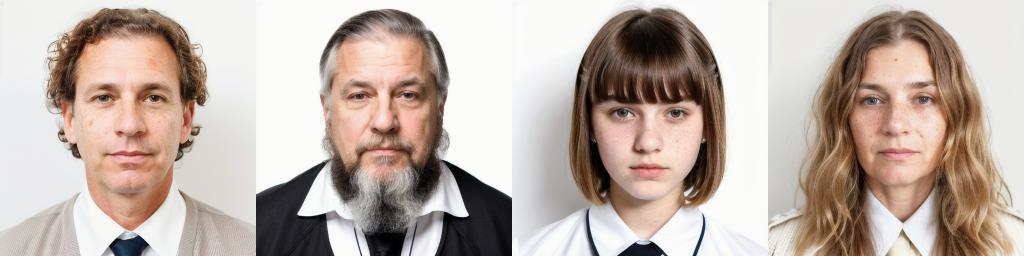

In [22]:
#@title { display-mode: "form", run: "auto" }

num_samples = 4 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 2 #@param {type:"slider", min:0, max:87, step:1}

latent_codes, sampled_images = load_images_as_latent_codes(generator)
#firstL = latent_codes[noise_seed*num_samples:noise_seed*num_samples+num_samples]
selected_latent_codes = latent_codes[noise_seed * num_samples:noise_seed * num_samples + num_samples]
selected_images = sampled_images[noise_seed * num_samples:noise_seed * num_samples + num_samples]

imshow(selected_images, col=num_samples)

# Edit facial attributes

[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


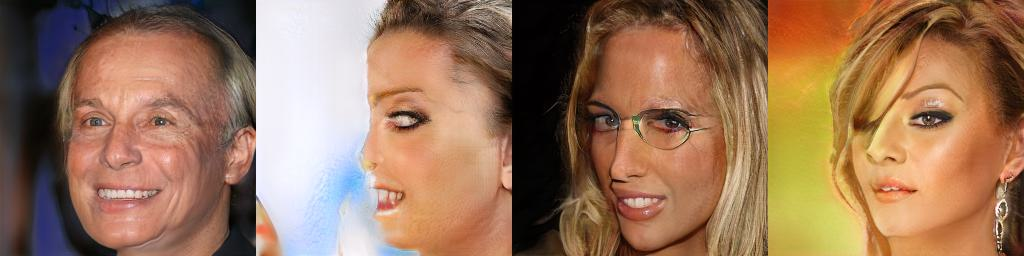

In [24]:
torch.backends.cudnn.enabled = False

modifications = {
    'age': 0.5,
    'eyeglasses': 3.0,
    'gender': -2.1,
    'pose': -2.1,
    'smile': 0.9
}

# Applica le modifiche ai codici latenti
new_codes = selected_latent_codes.copy()
for attr_name, value in modifications.items():
    if attr_name in boundaries:  # Assicurati che l'attributo esista nei confini
        boundary = boundaries[attr_name]
        new_codes += boundary * value

# Configura i parametri di sintesi
synthesis_kwargs = {'latent_space_type': latent_space_type} if generator.gan_type == 'stylegan' else {}

# Sintetizza le immagini con i codici latenti modificati
new_images_dict = generator.easy_synthesize(new_codes, **synthesis_kwargs)

# Estrai le immagini dal dizionario restituito
new_images = new_images_dict['image']

# Mostra le nuove immagini sintetizzate
imshow(new_images, col=len(new_images))